In [134]:
import mediapipe as mp
from mediapipe.python.solutions.pose import PoseLandmark
from pprint import pprint
from PIL import Image
import pandas as pd
from mediapipe.tasks import python as mpy
from mediapipe.tasks.python import vision
from pathlib import Path
import numpy as np
import cv2
from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
import matplotlib.pyplot as plt

In [135]:
# print(PoseLandmark.__dict__)
members = PoseLandmark._member_names_

In [136]:
# download one from here:
# https://ai.google.dev/edge/mediapipe/solutions/vision/pose_landmarker/index#models
model_path = "/Users/sidsurakanti/projects/what-punch/pose_landmarker_full.task"
# model_path = "/"

BaseOptions = mp.tasks.BaseOptions
PoseLandmarker = vision.PoseLandmarker
PoseLandmarkerOptions = vision.PoseLandmarkerOptions
running_mode = vision.RunningMode.IMAGE 
load_mp_img = mp.Image.create_from_file 

options = PoseLandmarkerOptions(
    base_options=BaseOptions(model_asset_path=model_path),
    running_mode=running_mode
)
detector = PoseLandmarker.create_from_options(options)

I0000 00:00:1750056573.270332  329114 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.4), renderer: Apple M3
W0000 00:00:1750056573.319011  350963 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1750056573.328343  350963 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


In [137]:
def draw_landmarks_on_image(rgb_image, detection_result):
  pose_landmarks_list = detection_result.pose_landmarks
  annotated_image = np.copy(rgb_image)

  for idx in range(len(pose_landmarks_list)):
    pose_landmarks = pose_landmarks_list[idx]

    # Draw the pose landmarks.
    pose_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
    pose_landmarks_proto.landmark.extend([
      landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in pose_landmarks
    ])
    solutions.drawing_utils.draw_landmarks(
      annotated_image,
      pose_landmarks_proto,
      solutions.pose.POSE_CONNECTIONS,
      solutions.drawing_styles.get_default_pose_landmarks_style())

  return annotated_image

In [145]:
results = []
folder = Path.cwd() / "assets" / "test"
# folder = Path("assets/test")

# [3:7]
for file in sorted(list(folder.glob("*.png"))):
    # img = Image.open(str(file))
    img = load_mp_img(str(file))
    # pprint(type(img).numpy_view.__doc__)
    # pprint(type(img).__doc__)
    
    landmarks = detector.detect(img)
    marks = landmarks.pose_world_landmarks[0] 
    results.append(marks)

    # pprint(type(marks[1]).__dict__)
    
    # print(img.numpy_view().shape)

    alpha_stripped = img.numpy_view()[..., :3]
    bgr_img = cv2.cvtColor(alpha_stripped, cv2.COLOR_RGB2BGR)
    annotated_image = draw_landmarks_on_image(bgr_img, landmarks)

    cv2.imshow("preview", annotated_image)
    key = cv2.waitKey(0)  # waits for key press
    if key == ord('q'): break
    cv2.destroyAllWindows()  # closes the window

In [146]:
data = []
for res in results:
    data.append([[lm.x, lm.y, lm.z, lm.visibility] for idx, (name, lm) in enumerate(zip(PoseLandmark._member_names_, res))])

data = np.array(data)
idxs = pd.MultiIndex.from_product([np.arange(data.shape[0]), np.arange(len(members))], names=["example", "landmark"])
df = pd.DataFrame(data.reshape(-1, 4), index=idxs, columns=["x", "y", "z", "visibility"])

In [147]:
df.loc[(0, 0): (7, 32)]

x         y         z  visibility
example landmark                                          
0       0         0.105812 -0.604585 -0.103344    0.999987
        1         0.112420 -0.642191 -0.089312    0.999982
        2         0.112934 -0.642498 -0.088762    0.999977
        3         0.112563 -0.643110 -0.088865    0.999981
        4         0.081429 -0.642052 -0.094331    0.999977
...                    ...       ...       ...         ...
7       28       -0.147712  0.689455  0.154659    0.650748
        29        0.160749  0.741853  0.134883    0.377621
        30       -0.152861  0.730250  0.165299    0.394567
        31        0.191442  0.817631  0.044039    0.453038
        32       -0.195052  0.784631  0.053016    0.504513

[264 rows x 4 columns]

In [148]:
df.describe()

,x,y,z,visibility
count,429.000000,429.000000,429.000000,429.000000
mean,0.027767,-0.236979,-0.085553,0.899220
std,0.135513,0.533444,0.134802,0.233769
min,-0.268276,-0.743480,-0.425817,0.000786
25%,-0.100560,-0.634104,-0.177412,0.950970
50%,0.066490,-0.523781,-0.094555,0.991095
75%,0.143804,0.010556,0.001391,0.999736
max,0.296398,0.898563,0.247267,0.999994


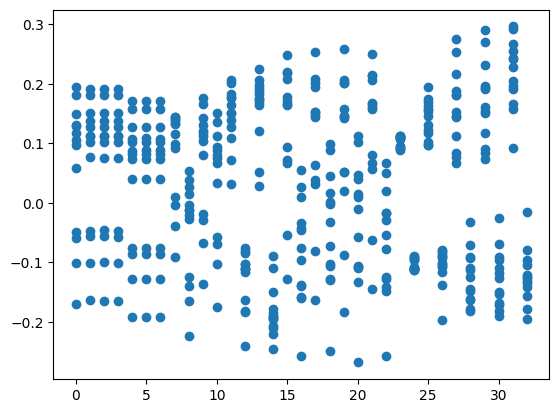

In [149]:
plt.scatter([x for x in df.index.get_level_values(1)], df['x'])

In [150]:
len(df)

429

In [151]:
members[15:24]

['LEFT_WRIST',
 'RIGHT_WRIST',
 'LEFT_PINKY',
 'RIGHT_PINKY',
 'LEFT_INDEX',
 'RIGHT_INDEX',
 'LEFT_THUMB',
 'RIGHT_THUMB',
 'LEFT_HIP']